# 기본 라이브러리

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mat

In [24]:
import platform

if platform.system() == 'Darwin':
    mat.rc('font', family='AppleGothic')
    mat.rcParams['axes.unicode_minus'] = False

In [25]:
df = pd.read_csv("dataTotal.csv")
df['탑승일자'] = pd.to_datetime(df['탑승일자'])

In [26]:
df = df.sort_values(by=['탑승일자'], ascending=[True])
df = df.drop_duplicates(subset=['탑승일자'], keep='first')
df.to_csv("dataTotal2.csv")

# 필요 함수

## 함수(1) : 성분분해

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 모든 변수에 대해 시계열 분해
def decompose_all_variables(df, columns, model_num, period):
    if model_num == 1: model = 'additive'
    elif model_num == 2: model = 'multiplicative'

    arr = []
    for col in columns:
        if col != '탑승일자':
            decomposed = seasonal_decompose(df[col], model=model, period=period)
            arr.append(decomposed)
    return arr

## 함수(2) : ACF 시각화

In [28]:
from statsmodels.tsa.stattools import acf

# ACF 계산 및 시각화 함수
def plot_acf(df, title, alpha=0.05, lags=40, threshold=0.2):
    variables = list(df.drop(labels='탑승일자', axis=1).columns)
    num_vars = len(variables)
    num_cols = 2
    num_rows = (num_vars + 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 3), sharex=True)
    fig.suptitle(title, fontsize=16)  # 전체 플롯 제목 설정
    axes = axes.flatten()  # 2D 배열을 1D로 변환
    
    for idx, var in enumerate(variables):
        data = df[var].dropna()
        acf_result = acf(data, alpha=alpha, nlags=lags)
        acf_values = acf_result[0]
        
        ax = axes[idx]
        ax.stem(range(len(acf_values)), acf_values, basefmt=" ", linefmt="blue", markerfmt="bo", label="ACF")
        ax.axhline(0, color="black", linestyle="--", linewidth=0.8, label="Zero Line")
        ax.axhline(threshold, color="red", linestyle="--", linewidth=1, label=f"Threshold (+{threshold})")
        ax.axhline(-threshold, color="green", linestyle="--", linewidth=1, label=f"Threshold (-{threshold})")
        ax.set_title(f"{var}의 ACF", fontsize=12)
        ax.set_xlabel("시차", fontsize=10)
        ax.set_ylabel("ACF", fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(loc="upper right", fontsize=8)
    
    # 빈 서브플롯 제거
    for idx in range(len(variables), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

## 함수(3) : PACF 시각화

In [29]:
from statsmodels.tsa.stattools import pacf
import matplotlib.pyplot as plt

# PACF 계산 및 시각화 함수
def plot_pacf(df, title, alpha=0.05, lags=40, threshold=0.2):
    variables = list(df.drop(labels='탑승일자', axis=1).columns)
    num_vars = len(variables)
    num_cols = 2
    num_rows = (num_vars + 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 3), sharex=True)
    fig.suptitle(title, fontsize=16)  # 전체 플롯 제목 설정
    axes = axes.flatten()  # 2D 배열을 1D로 변환
    
    for idx, var in enumerate(variables):
        data = df[var].dropna()
        pacf_result = pacf(data, alpha=alpha, nlags=lags, method='ols-adjusted')  # PACF 계산
        pacf_values = pacf_result[0]
        
        ax = axes[idx]
        ax.stem(range(len(pacf_values)), pacf_values, basefmt=" ", linefmt="blue", markerfmt="bo", label="PACF")
        ax.axhline(0, color="black", linestyle="--", linewidth=0.8, label="Zero Line")
        ax.axhline(threshold, color="red", linestyle="--", linewidth=1, label=f"Threshold (+{threshold})")
        ax.axhline(-threshold, color="green", linestyle="--", linewidth=1, label=f"Threshold (-{threshold})")
        ax.set_title(f"{var}의 PACF", fontsize=12)
        ax.set_xlabel("시차", fontsize=10)
        ax.set_ylabel("PACF", fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(loc="upper right", fontsize=8)
    
    # 빈 서브플롯 제거
    for idx in range(len(variables), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

## 함수(4) : 단위근 검정

In [30]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(df, sig_level):
    cols = list(df.drop(labels='탑승일자', axis=1).columns)
    nonst_cnt = 0
    nonst_col = []

    for col in cols:
        result = adfuller(df[str(col)])
        print(f"<df[{col}]의 통계량과 p-value>")
        stat, pvalue = result[0], result[1]

        print(f"통계량 : {round(stat, 3)}, p-value : {round(pvalue, 3)}")
        if pvalue < sig_level:
            print(f"귀무가설 기각: df[{col}]은 정상성을 만족합니다.")
        else:
            nonst_cnt += 1
            nonst_col.append(col)
            print(f"귀무가설 채택: df[{col}]은 정상성을 만족하지 않습니다.")

    print(f"정상성 만족하지 않은 변수의 종류 : {nonst_col}")
    print(f"정상성 만족하지 않은 변수의 갯수 : {nonst_cnt}개")

# 모형 1 : ARIMA

* $Z_t$ 에 해당하는 변수들을 고르고, 해당 변수들을 시각화 및 검정해서 차수 p, q, d를 정한다.

* 이후 ARIMA 모형에 적합시킨다.

In [31]:
# Z_t가 담길 데이터프레임을 df1으로 설정
df1 = df[['탑승일자', '1호선', '4호선', '공항철도', '경의선']]

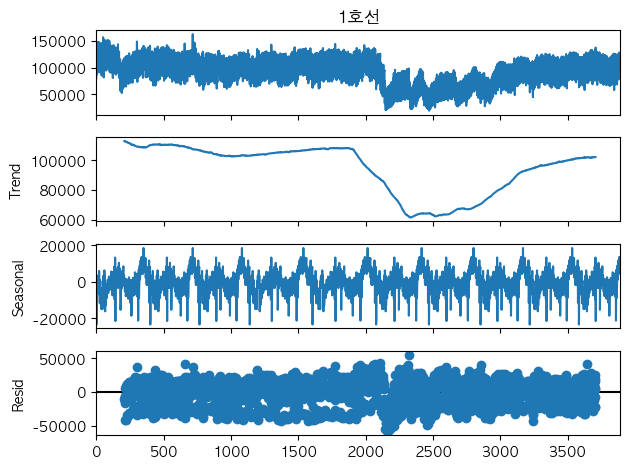

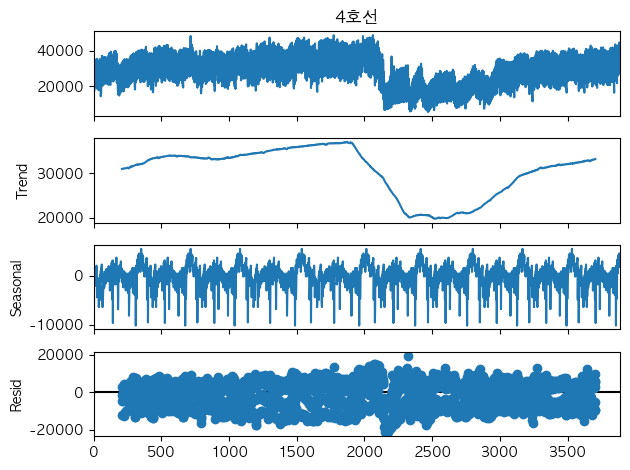

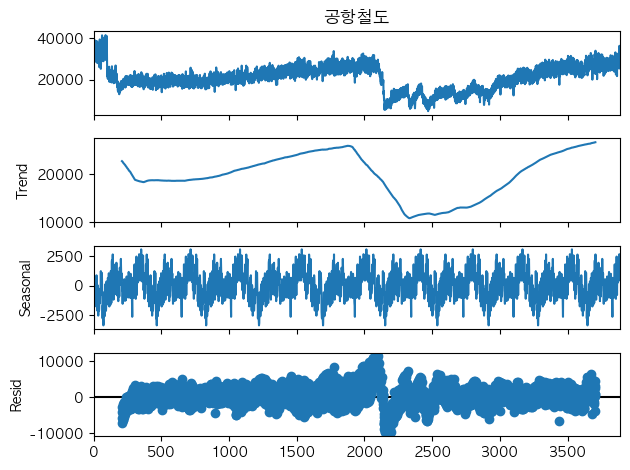

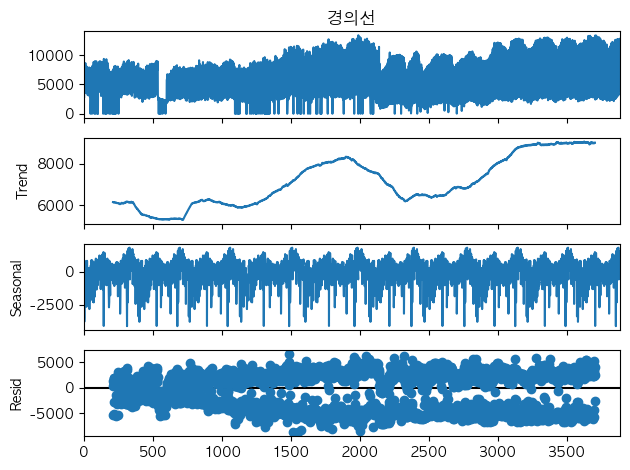

In [32]:
# 성분분해를 통해서 차분 I(d)의 차수 결정
# 변수 리스트
results = decompose_all_variables(df, df1.columns, 1, 365)      # 주기를 365로 해야 계절성을 파악할 수 있다.
for idx, result in enumerate(results):
    result.plot()
plt.show()

In [33]:
check_stationary(df1, 0.05)

<df[1호선]의 통계량과 p-value>
통계량 : -2.597, p-value : 0.094
귀무가설 채택: df[1호선]은 정상성을 만족하지 않습니다.
<df[4호선]의 통계량과 p-value>
통계량 : -2.537, p-value : 0.107
귀무가설 채택: df[4호선]은 정상성을 만족하지 않습니다.
<df[공항철도]의 통계량과 p-value>
통계량 : -2.629, p-value : 0.087
귀무가설 채택: df[공항철도]은 정상성을 만족하지 않습니다.
<df[경의선]의 통계량과 p-value>
통계량 : -3.74, p-value : 0.004
귀무가설 기각: df[경의선]은 정상성을 만족합니다.
정상성 만족하지 않은 변수의 종류 : ['1호선', '4호선', '공항철도']
정상성 만족하지 않은 변수의 갯수 : 3개


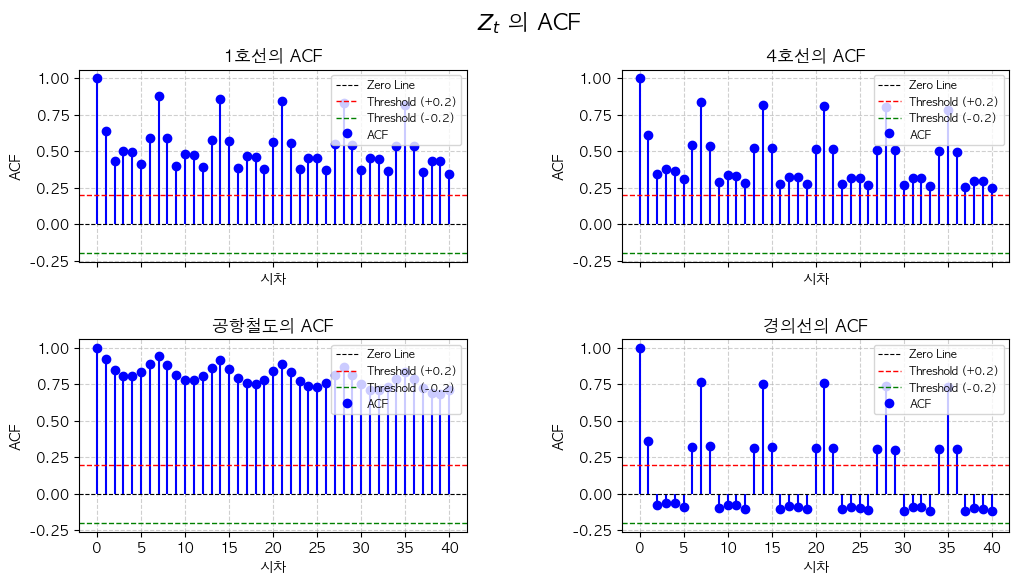

In [35]:
# ACF를 통해서 AR(p)에 해당하는 부분 결정
plot_acf(df1, r"$Z_t~$의 ACF")

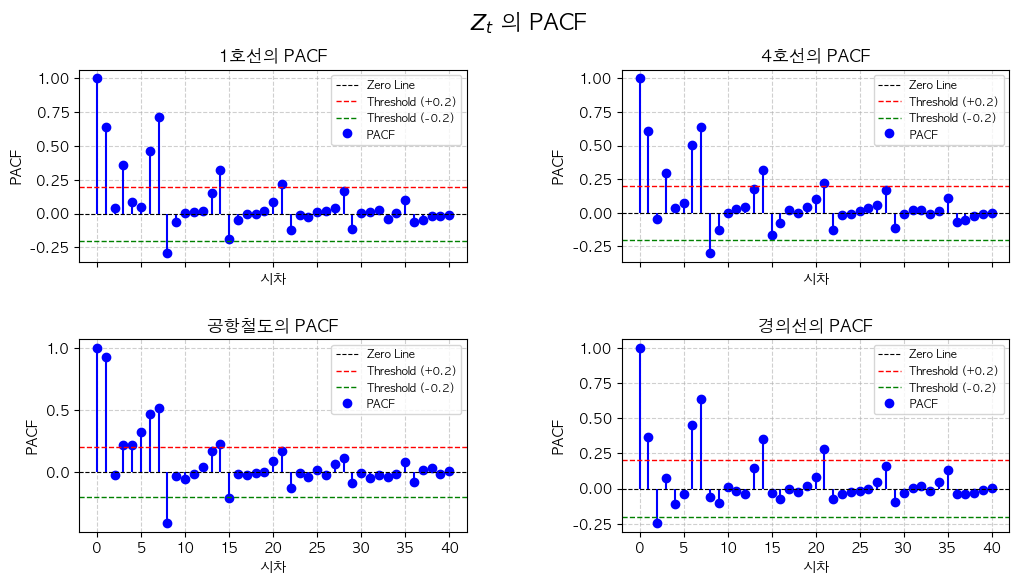

In [36]:
# PACF를 통해서 MA(q)에 해당하는 부분 결정
plot_pacf(df1, r"$Z_t~$의 PACF")

## 모형 적합

In [37]:
df1.set_index('탑승일자', inplace=True)
df1 = df1.asfreq('D')  # 데이터가 일별인 경우
df1 = df1[~df1.index.duplicated(keep='first')]  # 중복 제거
df1 = df1.sort_index()  # 인덱스 정렬

In [38]:
df1.head()

,1호선,4호선,공항철도,경의선
탑승일자,,,,
2015-01-01,80394.0,14766.0,24498.0,2873.0
2015-01-02,135476.0,30619.0,36337.0,7219.0
2015-01-03,103156.0,21242.0,31520.0,4023.0
2015-01-04,86802.0,17294.0,28913.0,3590.0
2015-01-05,129718.0,30790.0,35101.0,8307.0


In [39]:
# train / test 분리
df1_train = df1.loc['2015-01-01':'2022-12-31']  # 인덱스를 기준으로 슬라이싱
print(df1_train.tail(), end='\n\n')

df1_test = df1.loc['2022-12-31':]  # 인덱스를 기준으로 슬라이싱
print(df1_test.tail())

                 1호선      4호선     공항철도      경의선
탑승일자                                           
2022-12-27  101954.0  33889.0  21252.0  10293.0
2022-12-28  103652.0  34094.0  21230.0  10519.0
2022-12-29  104708.0  33734.0  22070.0  10086.0
2022-12-30  109068.0  32556.0  24514.0   9744.0
2022-12-31   76430.0  21736.0  19405.0   2525.0

                 1호선      4호선     공항철도      경의선
탑승일자                                           
2024-10-27  124598.0  41763.0  36351.0   5769.0
2024-10-28  111814.0  39012.0  28125.0  12584.0
2024-10-29  109220.0  39536.0  25445.0  12691.0
2024-10-30  110730.0  39683.0  26052.0  12548.0
2024-10-31  113842.0  39746.0  27893.0  12762.0


In [40]:
# train을 적합
from statsmodels.tsa.arima.model import ARIMA

fitmodels = []
orders = [[1, 1, 0], [1, 1, 2], [1, 1, 3], [1, 0, 2]]
columns = list(df1_train.columns)

# 모델 생성 및 학습
model = ARIMA(df1_train['1호선'], order=orders[0])
fit1 = model.fit()

model = ARIMA(df1_train['4호선'], order=orders[1])
fit2 = model.fit()

model = ARIMA(df1_train['공항철도'], order=orders[2])
fit3 = model.fit()

model = ARIMA(df1_train['경의선'], order=orders[3])
fit4 = model.fit()

fitmodels = [fit1, fit2, fit3, fit4]

<Figure size 1000x600 with 0 Axes>

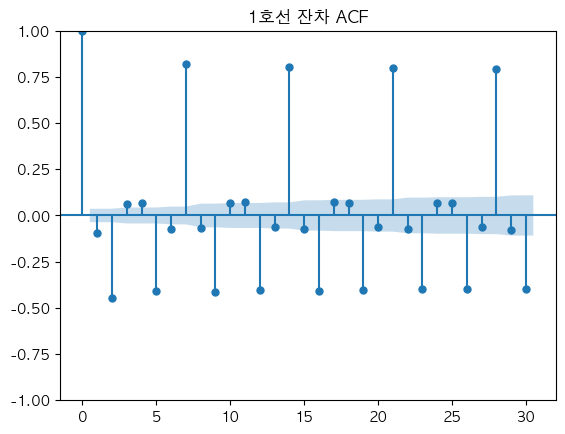

<Figure size 1000x600 with 0 Axes>

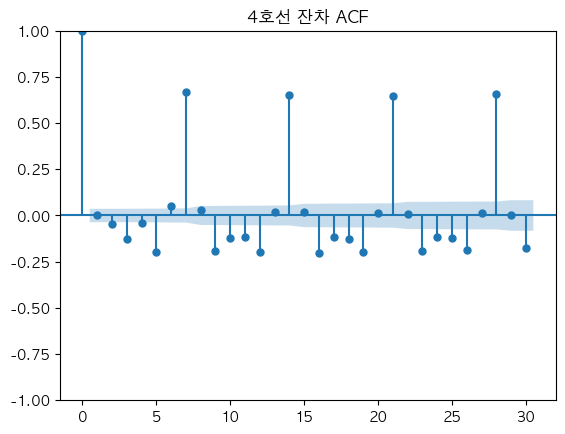

<Figure size 1000x600 with 0 Axes>

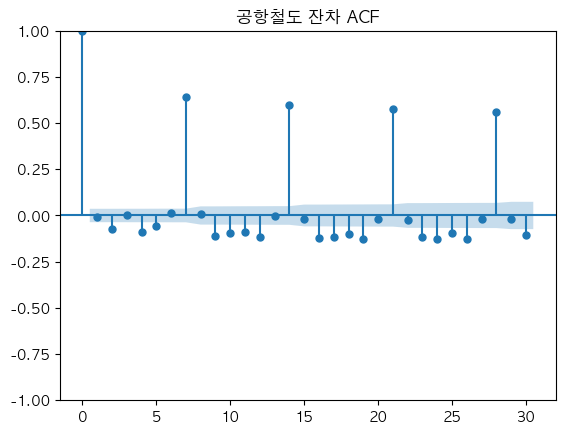

<Figure size 1000x600 with 0 Axes>

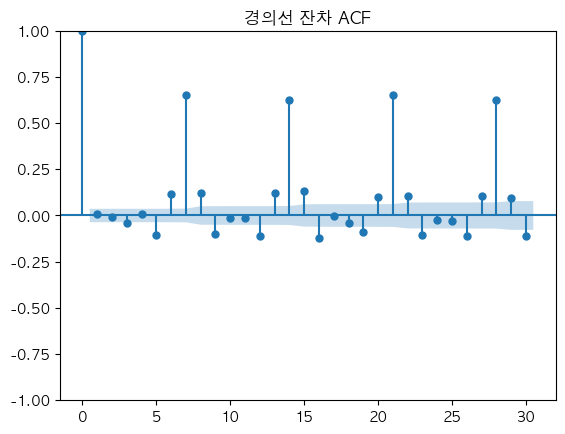

In [41]:
from statsmodels.graphics.tsaplots import plot_acf

for idx, model in enumerate(fitmodels):
    residuals = model.resid  # 모델의 잔차

    # ACF 플롯
    plt.figure(figsize=(10, 6))
    plot_acf(residuals, lags=30)  # 최대 30 래그까지 표시
    plt.title(f'{columns[idx]} 잔차 ACF')
    plt.show()

In [42]:
for idx, model in enumerate(fitmodels):
    forecast_steps = len(df1_test)  # 테스트 데이터 길이
    forecast = fit1.forecast(steps=forecast_steps)
    print(forecast)

2023-01-01    83408.677405
2023-01-02    81916.492273
2023-01-03    82235.552224
2023-01-04    82167.330627
2023-01-05    82181.917811
                  ...     
2024-10-28    82179.348205
2024-10-29    82179.348205
2024-10-30    82179.348205
2024-10-31    82179.348205
2024-11-01    82179.348205
Freq: D, Name: predicted_mean, Length: 671, dtype: float64
2023-01-01    83408.677405
2023-01-02    81916.492273
2023-01-03    82235.552224
2023-01-04    82167.330627
2023-01-05    82181.917811
                  ...     
2024-10-28    82179.348205
2024-10-29    82179.348205
2024-10-30    82179.348205
2024-10-31    82179.348205
2024-11-01    82179.348205
Freq: D, Name: predicted_mean, Length: 671, dtype: float64
2023-01-01    83408.677405
2023-01-02    81916.492273
2023-01-03    82235.552224
2023-01-04    82167.330627
2023-01-05    82181.917811
                  ...     
2024-10-28    82179.348205
2024-10-29    82179.348205
2024-10-30    82179.348205
2024-10-31    82179.348205
2024-11-01    8217

# 모형 2 : 삼중지수평활법

Processing variable: 1호선
 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 924649185421.7878
       x: [ 7.496e-02  7.626e-02]
     nit: 2
     jac: [ 1.121e+11  1.379e+10]
    nfev: 8
    njev: 2


/Users/inchoi/timeSeries/myenv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


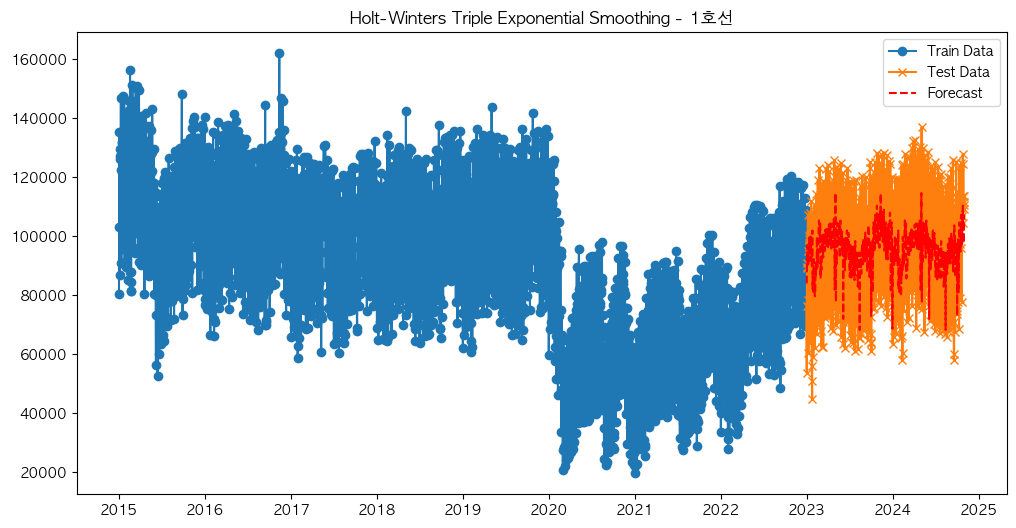

Processing variable: 4호선


/Users/inchoi/timeSeries/myenv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 133919969086.20973
       x: [ 5.214e-02  9.247e-02]
     nit: 1
     jac: [-2.820e+10 -4.272e+07]
    nfev: 3
    njev: 1


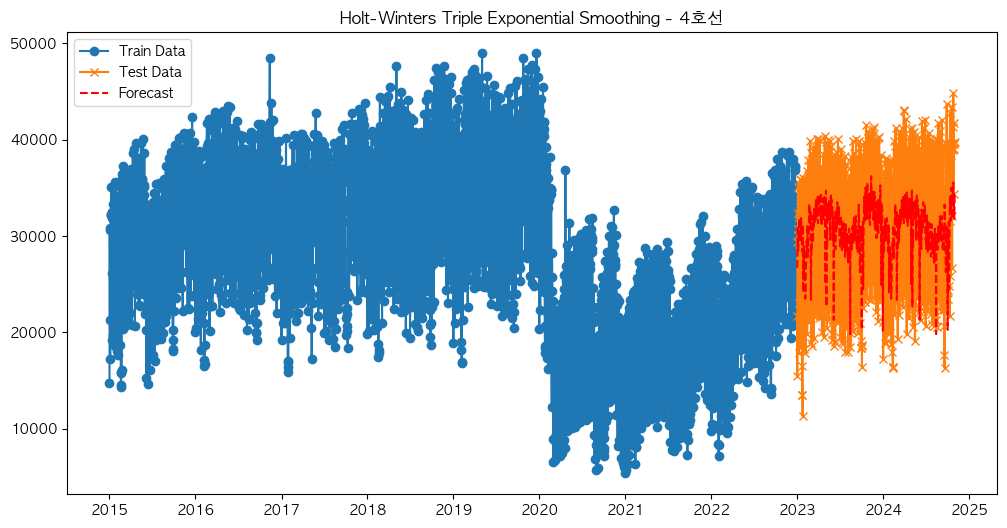

Processing variable: 공항철도
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 16455451466.630924
       x: [ 7.593e-01  1.490e-01]
     nit: 5
     jac: [-5.001e+07  4.161e+07]
    nfev: 3
    njev: 1


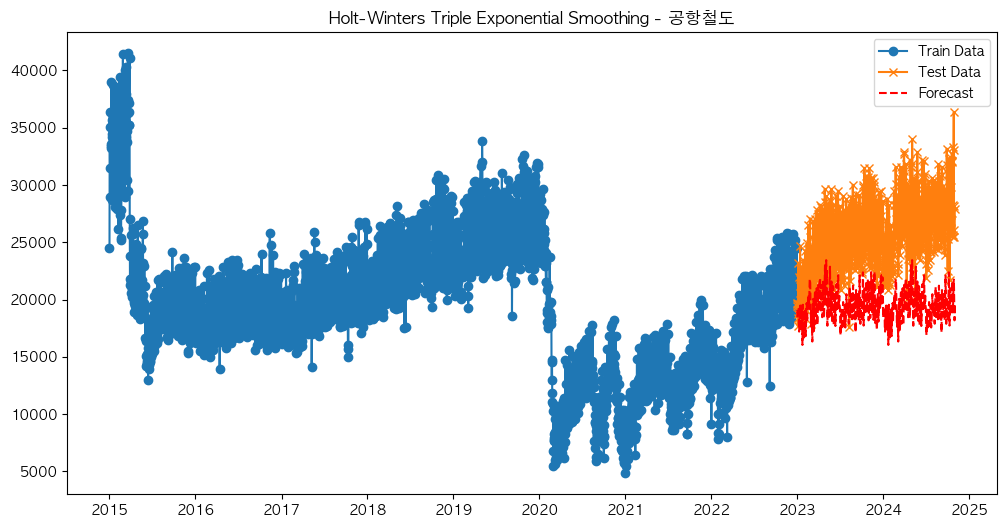

Processing variable: 경의선
 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 33836808009.384697
       x: [ 2.857e-02  9.252e-02]
     nit: 1
     jac: [-1.303e+09 -5.252e+08]
    nfev: 3
    njev: 1


/Users/inchoi/timeSeries/myenv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


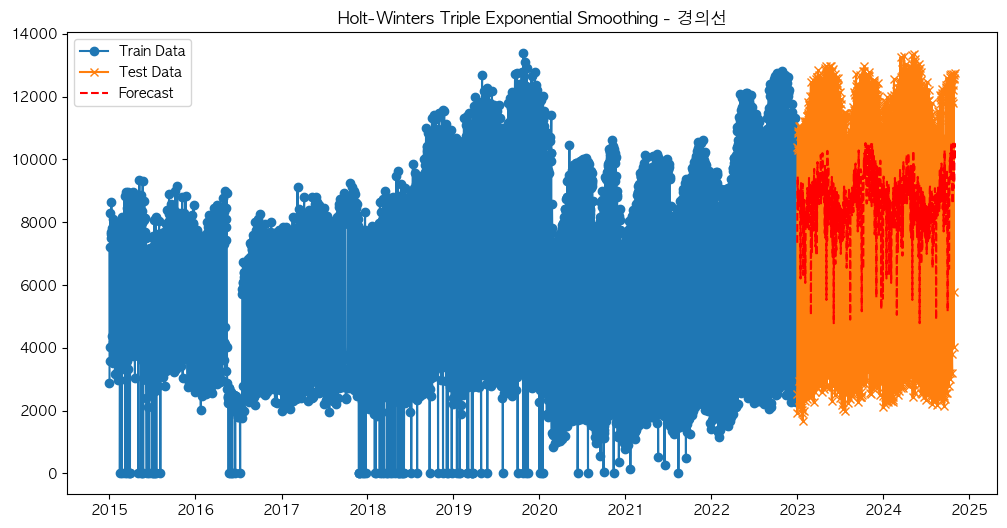

In [58]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
df1 = df.copy()

# 분석할 열 목록
variables = ['1호선', '4호선', '공항철도', '경의선']

# 2. 각 변수에 대해 삼중 지수 평활법 적용 및 테스트 데이터와 비교
for var in variables:
    print(f"Processing variable: {var}")
    
    # 훈련 데이터 추출
    ts_train = df1_train[var]
    
    # 테스트 데이터 추출
    ts_test = df1_test[var]

    # 삼중 지수 평활법 모델 생성
    model = ExponentialSmoothing(
        ts_train,
        seasonal='add',  # 계절성 가법 모델
        seasonal_periods = 365,  # 계절 주기
        initialization_method='heuristic'
    )
    
    # 모델 피팅
    fit_model = model.fit()
    print(fit_model.mle_retvals)  # 최적화 상태 확인

    # 테스트 기간에 대한 예측
    forecast = fit_model.forecast(len(ts_test))
    
    # 3. 결과 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(ts_train, label="Train Data", marker="o")
    plt.plot(ts_test, label="Test Data", marker="x")
    plt.plot(forecast, label="Forecast", color="red", linestyle="--")
    plt.title(f"Holt-Winters Triple Exponential Smoothing - {var}")
    plt.legend()
    plt.show()